In [1]:
import numpy as np
import math
from PIL import Image
import glob
import time
from six.moves import cPickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load dataset 

In [2]:
IMAGE_PATH = 'iccv09Data/images/'
height = 240
width = 320
resize_ratio = 3
n_image = 0

file_list = glob.glob(IMAGE_PATH + '*.jpg')

for i, file in enumerate(file_list):
    img = Image.open(file)
    img_array = np.array(img)
    if img_array.shape[0] == height and img_array.shape[1] == width:
        n_image += 1
        
        rgb_img = img_array.reshape(1, height, width, 3)
        
        img_low = img.resize((int(width/resize_ratio), int(height/resize_ratio)), Image.BICUBIC)
        img_low = img_low.resize((width, height), Image.BICUBIC)    # Image low resolution
        rgb_img_low = np.array(np.float32(img_low)/255.)            # Convert image low resolution to array
        rgb_img_low = rgb_img_low.reshape(1, height, width, 3)
        
        #Convert rgb_img and rgb_img_low to shape (1, 230400)
        rgb_img = np.reshape(rgb_img, [1, -1])
        rgb_img_low = np.reshape(rgb_img_low, [1, -1])
        
        if n_image == 1:
            data = rgb_img
            data_low = rgb_img_low
        else:
            data = np.concatenate((data, rgb_img), axis=0)
            data_low = np.concatenate((data_low, rgb_img_low), axis=0)
        
print('Number images is:', n_image)
print('Shape of data is: ', data.shape)
print('Shape of data_low is: ', data_low.shape)

Number images is: 531
Shape of data is:  (531, 230400)
Shape of data_low is:  (531, 230400)


# Divide into 2 datasets
## (x_train, y_train) and (x_test, y_test)

In [3]:
rand_idx = np.random.permutation(n_image)
n_train = int(n_image*0.7)
n_test = n_image - n_train

x_train = data_low[rand_idx[0:n_train], :]
y_train = data[rand_idx[0:n_train], :]
x_test = data_low[rand_idx[n_train:n_image], :]
y_test = data[rand_idx[n_train:n_image], :]

print('Shape of x_train is', x_train.shape)
print('Shape of y_train is', y_train.shape)
print('Shape of x_test is', x_test.shape)
print('Shape of y_test is', y_test.shape)

Shape of x_train is (371, 230400)
Shape of y_train is (371, 230400)
Shape of x_test is (160, 230400)
Shape of y_test is (160, 230400)


# Plot some images

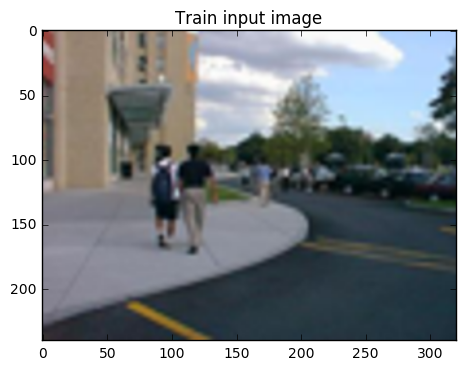

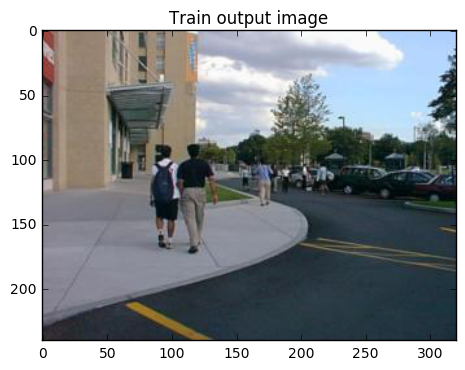

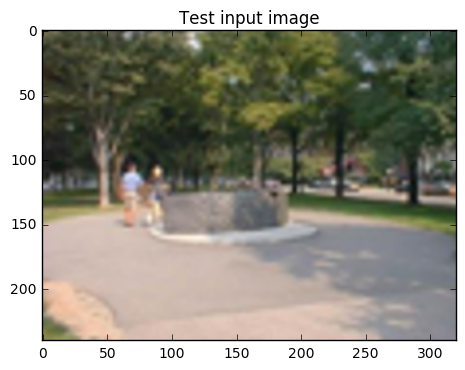

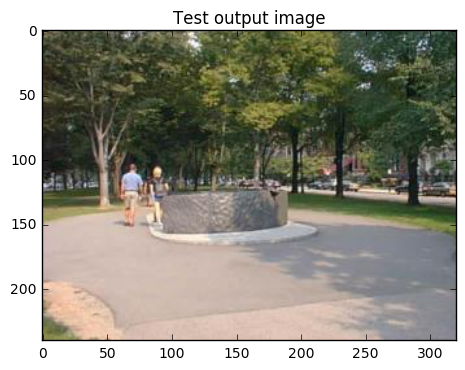

In [4]:
#Train
rand_idx = np.random.randint(n_train)
current_x = x_train[rand_idx, :]
current_x = np.reshape(current_x, newshape=[height, width, 3])
plt.imshow(current_x)
plt.title('Train input image')
plt.show()
current_y = y_train[rand_idx, :]
current_y = np.reshape(current_y, newshape=[height, width, 3])
plt.imshow(current_y)
plt.title('Train output image')
plt.show()

#Test
rand_idx = np.random.randint(n_test)
current_x = x_test[rand_idx, :]
current_x = np.reshape(current_x, newshape=[height, width, 3])
plt.imshow(current_x)
plt.title('Test input image')
plt.show()
current_y = y_test[rand_idx, :]
current_y = np.reshape(current_y, newshape=[height, width, 3])
plt.imshow(current_y)
plt.title('Test output image')
plt.show()

# Define Network

In [5]:
#Params
n1 = 32
n2 = 64
n3 = 64
n4 = 64
n5 = 64
n6 = 3
k_size = 3
dim = height*width*3
learning_rate = 0.001
batch_size = 16
epochs = 1000   #should be 100000

#Weights & Biases
weights = {
    'ce1': tf.Variable(tf.random_normal(shape=[k_size, k_size, 3, n1], stddev=0.01)),
    'ce2': tf.Variable(tf.random_normal(shape=[k_size, k_size, n1, n2], stddev=0.01)),
    'ce3': tf.Variable(tf.random_normal(shape=[k_size, k_size, n2, n3], stddev=0.01)),
    'ce4': tf.Variable(tf.random_normal(shape=[k_size, k_size, n3, n4], stddev=0.01)),
    'ce5': tf.Variable(tf.random_normal(shape=[k_size, k_size, n4, n5], stddev=0.01)),
    'ce6': tf.Variable(tf.random_normal(shape=[k_size, k_size, n5, n6], stddev=0.01))
}

biases = {
    'be1': tf.Variable(tf.random_normal(shape=[n1], stddev=0.01)),
    'be2': tf.Variable(tf.random_normal(shape=[n2], stddev=0.01)),
    'be3': tf.Variable(tf.random_normal(shape=[n3], stddev=0.01)),
    'be4': tf.Variable(tf.random_normal(shape=[n4], stddev=0.01)),
    'be5': tf.Variable(tf.random_normal(shape=[n5], stddev=0.01)),
    'be6': tf.Variable(tf.random_normal(shape=[n6], stddev=0.01))
}

#Place holders
x = tf.placeholder(dtype=tf.float32, shape=[None, dim])
y = tf.placeholder(dtype=tf.float32, shape=[None, dim])
keep_prob = tf.placeholder(dtype=tf.float32)

# Superres function

In [6]:
def superres_nn(x, weights, biases, keep_prob):
    input_r = tf.reshape(tensor=x, shape=[-1, height, width, 3])
    #Encoder
    ce1 = tf.nn.relu(tf.add(tf.nn.conv2d(input_r, filter=weights['ce1'], strides=[1,1,1,1], padding='SAME'), biases['be1']))
    ce1 = tf.nn.dropout(ce1, keep_prob)
    
    ce2 = tf.nn.relu(tf.add(tf.nn.conv2d(ce1, filter=weights['ce2'], strides=[1,1,1,1], padding='SAME'), biases['be2']))
    ce2 = tf.nn.dropout(ce2, keep_prob)
    
    ce3 = tf.nn.relu(tf.add(tf.nn.conv2d(ce2, filter=weights['ce3'], strides=[1,1,1,1], padding='SAME'), biases['be3']))
    ce3 = tf.nn.dropout(ce3, keep_prob)
    
    ce4 = tf.nn.relu(tf.add(tf.nn.conv2d(ce3, filter=weights['ce4'], strides=[1,1,1,1], padding='SAME'), biases['be4']))
    ce4 = tf.nn.dropout(ce4, keep_prob)
    
    ce5 = tf.nn.relu(tf.add(tf.nn.conv2d(ce4, filter=weights['ce5'], strides=[1,1,1,1], padding='SAME'), biases['be5']))
    ce5 = tf.nn.dropout(ce5, keep_prob)
    
    ce6 = tf.nn.relu(tf.add(tf.nn.conv2d(ce5, filter=weights['ce6'], strides=[1,1,1,1], padding='SAME'), biases['be6']))
    out = ce6 + input_r
    
    return {
        'input_r': input_r,
        'ce1': ce1,
        'ce2': ce2,
        'ce3': ce3,
        'ce4': ce4,
        'ce5': ce5,
        'ce6': ce6,
        'layers': (input_r, ce1, ce2, ce3, ce4, ce5, ce6),
        'out': out}

# Other functions

In [7]:
y_pred = superres_nn(x, weights, biases, keep_prob)['out']

loss = tf.reduce_mean(tf.square(y_pred - tf.reshape(y, shape=[-1, height, width, 3])))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

# Training and Plot

[0/1000] loss: 3291.8835
Training dataset


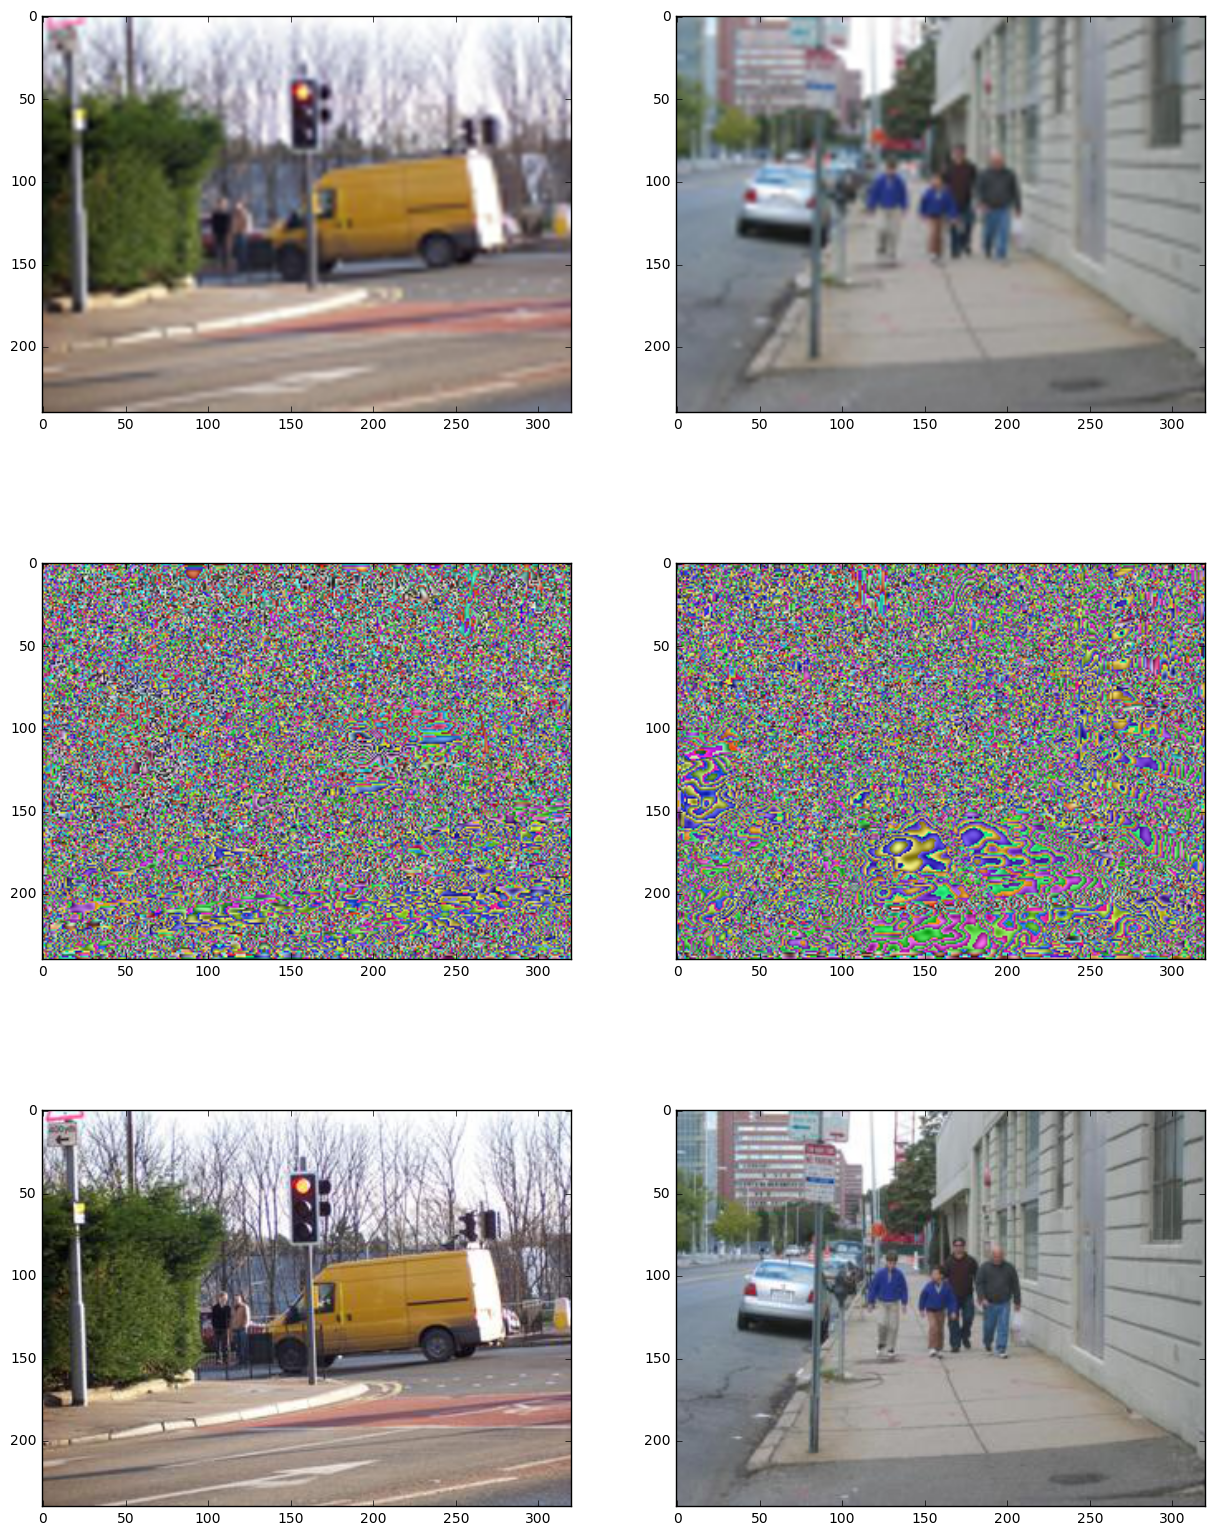

Test dataset


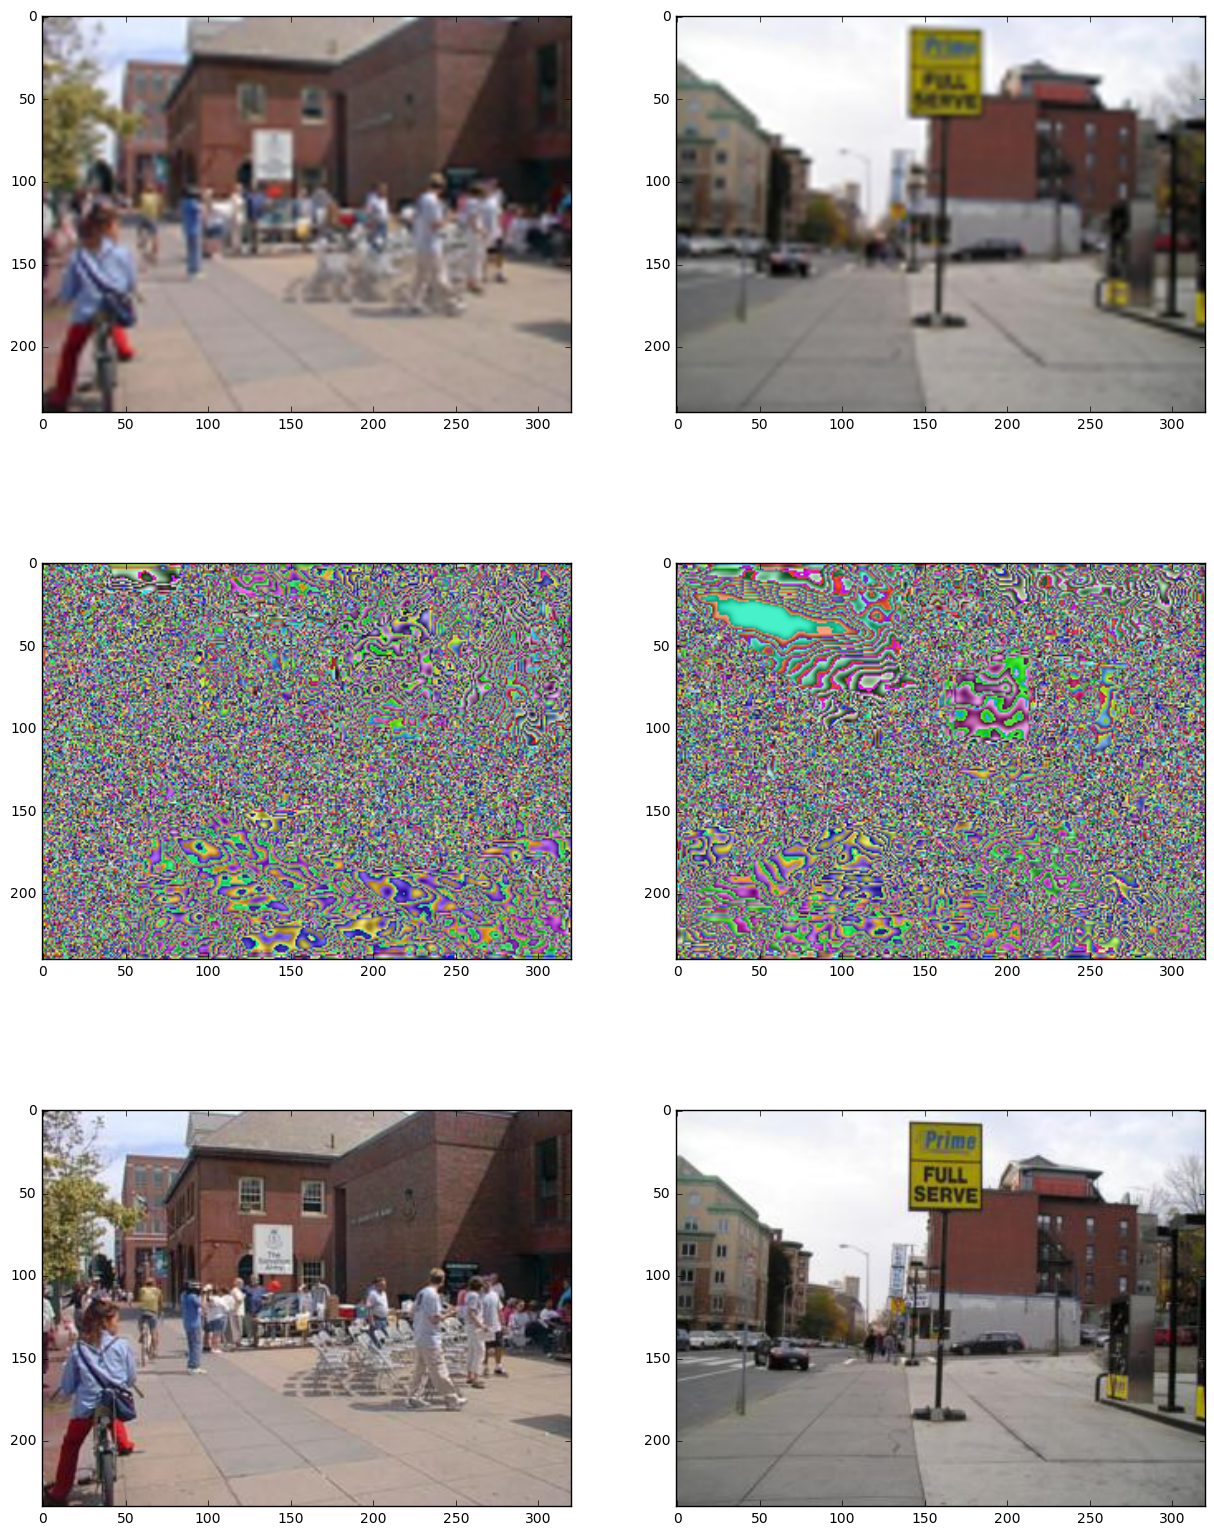

[10/1000] loss: 637.0898
[20/1000] loss: 610.4328


KeyboardInterrupt: 

In [10]:
sess = tf.Session()
sess.run(init)

for epoch in range(epochs):
    for batch_i in range(n_train // batch_size):
        rand_idx = np.random.randint(n_train, size=batch_size)
        batch_x = x_train[rand_idx, :]
        batch_y = y_train[rand_idx, :]
        
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
        
    if epoch % 10 == 0:
        print('[%d/%d] loss: %.4f' % (epoch, epochs, sess.run(loss, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})))
        
    if epoch % 100 == 0:
        n_examples = 2
        
        print('Training dataset')
        rand_idx = np.random.randint(n_train, size=n_examples)
        train_x = x_train[rand_idx, :]
        train_y = y_train[rand_idx, :]
        predict = sess.run(y_pred, feed_dict={x: train_x, keep_prob:1.0})
        #Plot training examples
        fig, axes = plt.subplots(3, n_examples, figsize=(15,20))
        for example_i in range(n_examples):
            axes[0][example_i].imshow(np.reshape(train_x[example_i, :], newshape=[height, width, 3]))
            axes[1][example_i].imshow(np.reshape(predict[example_i, :], newshape=[height, width, 3]))
            axes[2][example_i].imshow(np.reshape(train_y[example_i, :], newshape=[height, width, 3]))
        plt.show()
        
        print('Test dataset')
        rand_idx = np.random.randint(n_test, size=n_examples)
        test_x = x_test[rand_idx, :]
        test_y = y_test[rand_idx, :]
        predict = sess.run(y_pred, feed_dict={x: test_x, keep_prob:1.0})
        #Plot test examples
        fig, axes = plt.subplots(3, n_examples, figsize=(15,20))
        for example_i in range(n_examples):
            axes[0][example_i].imshow(np.reshape(test_x[example_i, :], newshape=[height, width, 3]))
            axes[1][example_i].imshow(np.reshape(predict[example_i, :], newshape=[height, width, 3]))
            axes[2][example_i].imshow(np.reshape(test_y[example_i, :], newshape=[height, width, 3]))
        plt.show()